This notebook introduces the use of the morphodynamical trajectory embedding method on a live-cell imaging dataset of MCF10A cells responding to EGF over 48 hours (30 minutes between frames), see Morphodynamical cell-state description via live-cell imaging trajectory embedding
Jeremy Copperman, Sean M. Gross, Young Hwan Chang, Laura M. Heiser, Daniel M. Zuckerman, bioRxiv (2021) doi: https://doi.org/10.1101/2021.10.07.463498
For celltraj code installation and python environment requirements, see installation instructions https://jcopperm.github.io/celltraj/installation.html

In [1]:
%%capture
import matplotlib.pyplot as plt
import numpy as np
import celltraj.trajectory

An example dataset is available at https://figshare.com/articles/dataset/EGF1_17nov20_h5/20721685 which is an h5 file containing the raw images, cell segmentations, and foreground masks. Download this data and move to the same folder as this tutorial.

In [2]:
fileSpecifier = 'EGF1_17nov20.h5' #live-cell imaging data file with images, cell masks (labels), and foreground masks
modelName = 'mcf10a_EGF' #data label for outputs
sctm = celltraj.trajectory.Trajectory() #single-cell trajectory model (sctm) object
sctm.initialize(fileSpecifier, modelName)

In [3]:
%%capture
sctm.get_frames() #get number of frames
start_frame=0
end_frame=sctm.maxFrame
sctm.get_imageSet(start_frame,end_frame); #pull image data into sctm for analysis
sctm.get_fmaskSet(start_frame,end_frame); #pull foreground/background masks

These are unlabeled phase contrast images of MCF10A mammary epithelial cells in 2D culture in EGF containing media. Lets see what these images look like

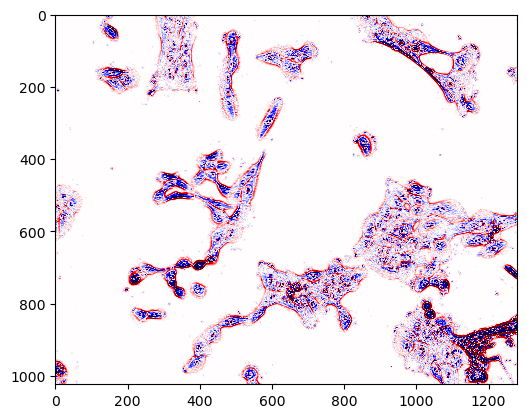

In [4]:
from IPython.display import clear_output
plt.clf()
for i in range(end_frame):
    clear_output(wait=True)
    plt.imshow(sctm.imgSet[i,:,:],cmap=plt.cm.seismic,clim=(-3,3))
    plt.pause(.2)

Cell segmentation was performed in cellpose (cellpose.org). For the the cells that were segmented in the image set, we extract the single-cell features.

In [5]:
%%capture
sctm.get_imageSet_trans_turboreg() #register images
sctm.get_cell_data()  #gather single-cell label information
sctm.get_cell_images() #extract single-cell images
sctm.get_cellborder_images() #extract cellborder images
sctm.prepare_cell_images() #prepare single-cell images f
sctm.prepare_cell_features(apply_znorm=False) #extract single-cell zernike moments, texture, 

We now track cells (linking cells between frames) by first aligning each connected cell cluster and then linking cells by segmentation overlap. In this label-free imaging setting, segmentation and tracking errors are abundant, but the morphodynamical trajectory embedding method can still leverage trajectory information to improve single-cell characterization, see https://doi.org/10.1101/2021.10.07.463498.

In [6]:
%%capture
sctm.visual=False
sctm.get_lineage_bunch_overlap() #tracking cells between frames 

We can examine the morphological feature space by looking at a PCA decomposition. Coloring these PCAs by individual features (here the fraction of the cell boundary making cell-cell contact) provides insight into the heterogeneity of the cell morphology.

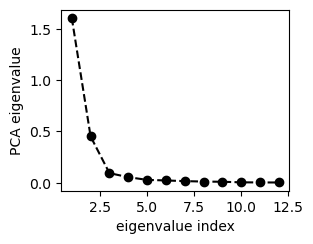

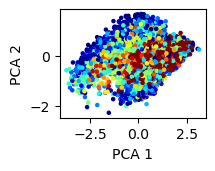

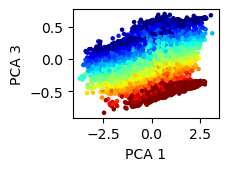

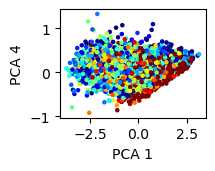

In [7]:
sctm.get_pca() #get pca coordinates from cell features
sctm.visual=True; sctm.plot_pca(colors=sctm.Xf[:,sctm.indfcb[0]]) #the feature being colored is practically the fraction of the cell boundary making cell-cell contact

Lets see what typical single-cell trajectories look like in the cell morphology feature PCA space.

In [8]:
%%capture
sctm.get_unique_trajectories() #assemble trajectories from cell tracking linkages
traj_lengths=np.array([])
for itraj in range(len(sctm.trajectories)): #iterate over trajectories and get trajectory lengths
    traj_lengths=np.append(traj_lengths,sctm.trajectories[itraj].size)
    
indtrajs=np.argsort(traj_lengths) #just a length ordered array of trajectory indices

In [9]:
def show_cell_trajectory(self,cell_traj,x=None,traj=None,nbins=20): #make a plot of cell coordinate and single-cell images along a cell trajectory
    if x is None:
        x=self.Xtraj
    if traj is None:
        traj=self.traj
    plt.figure(figsize=(9,4))
    prob,xedges1,yedges1=np.histogram2d(x[:,0],x[:,1],bins=nbins,density=True) #coordinate landscape probability distribution
    xx,yy=np.meshgrid(.5*xedges1[1:]+.5*xedges1[0:-1],.5*yedges1[1:]+.5*yedges1[0:-1]) #grid coordinates
    xt,inds_traj=sctm.get_Xtraj_celltrajectory(cell_traj,Xtraj=x,traj=traj) #get coordinates, cell indices along trajectory set
    cell_traj=sctm.traj[inds_traj,-1]
    nt=cell_traj.size
    icell=cell_traj[-1]; iS=1;
    for itt in range(nt):
        clear_output(wait=True)
        plt.clf()
        plt.subplot(1,2,1)
        cs=plt.contourf(xx,yy,prob.T,cmap=plt.cm.Greys,extend='both')
        cs.cmap.set_over('black')
        plt.axis('off')
        ax=plt.gca()
        for ittt in range(itt-1):
            ax.arrow(xt[ittt,0],xt[ittt,1],xt[ittt+1,0]-xt[ittt,0],xt[ittt+1,1]-xt[ittt,1],head_width=.2,linewidth=1.0,color=plt.cm.winter(ittt/nt),alpha=1.0)
        plt.subplot(1,2,2)
        sctm.get_cellborder_images(indcells=np.array([cell_traj[itt]]),bordersize=80)
        imgcell=sctm.cellborder_imgs[0]
        mskcell=sctm.cellborder_msks[0]
        fmskcell=sctm.cellborder_fmsks[0]
        ccborder,csborder=sctm.get_cc_cs_border(mskcell,fmskcell)
        plt.imshow(np.ma.masked_where(fmskcell == 0, imgcell),cmap=plt.cm.seismic,clim=(-10,10),alpha=1.0)
        plt.imshow(np.ma.masked_where(fmskcell == 1, imgcell),cmap=plt.cm.gray,clim=(-10,10),alpha=0.6)
        nx=imgcell.shape[0]; ny=imgcell.shape[1]
        xxc,yyc=np.meshgrid(np.arange(nx),np.arange(ny),indexing='ij')
        cmskx=np.sum(np.multiply(xxc,mskcell))/np.sum(mskcell)
        cmsky=np.sum(np.multiply(yyc,mskcell))/np.sum(mskcell)
        scatter_x=plt.scatter(cmsky,cmskx,s=600,color='black',marker='x',alpha=0.6)
        plt.axis('off')
        plt.pause(.33)

extracting cellborders from frame 87 image 0
cell: 1 smaller than minsize of 1


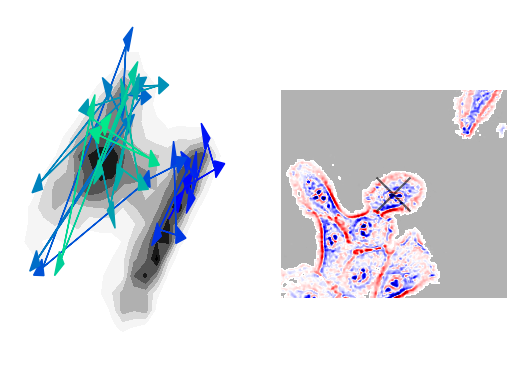

In [10]:
sctm.trajl=1
sctm.traj=sctm.get_traj_segments(1) #get trajectory segments, to be consistent with trajectory embeddings
cell_traj=sctm.trajectories[indtrajs[-6]]
show_cell_trajectory(sctm,cell_traj,x=sctm.Xpca[:,0:2],traj=sctm.traj)

In the single-timepoint morphological feature space the trajectory appears pretty random. Now lets see what this trajectory looks like in a morphodynamical trajectory embedding space (trajectory length of 8, or 3.5 hours)

extracting cellborders from frame 87 image 0
cell: 1 smaller than minsize of 1


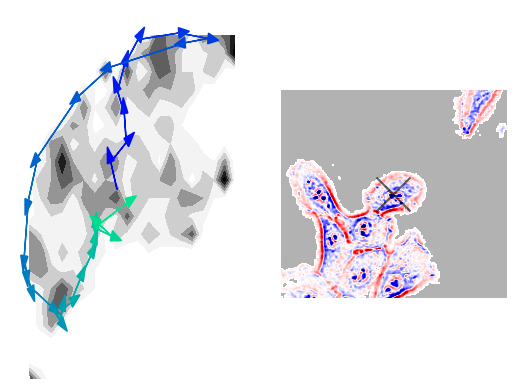

In [25]:
sctm.get_trajectory_embedding(9,embedding_type='UMAP',neigen=2,get_trajectories=False) #concatenates pca features along trajectories of length 11 (5 hours), and then embeds morphodynamical feature trajectory into a UMAP of dimension 2 
show_cell_trajectory(sctm,sctm.trajectories[indtrajs[-6]],x=sctm.Xtraj,traj=sctm.traj)

In the morphodynamical trajectory embedding space, you can begin to see consistent cell state transition pathways even in this single condition and single field-of-view limited dataset. 